In [ ]:
import numpy as np
import pandas as pd
import os
import gzip
import io
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4.1 Анализ текста сообщений

Смотрим на столбец `serv_mess`

In [ ]:
# vibo: читаем предобработанный лог (index_col=0 считываем индексы тоже)
data_logs = pd.read_csv('/content/drive/MyDrive/minecraft/logs.csv', index_col=0)

In [ ]:
data_logs

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,plug_name,plug_mess
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6577,2023-03-09,18:50:50,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,5.0,NaN,NaN,NaN,NaN
6578,2023-03-09,18:50:50,Server thread,INFO,ARTEXX joined the game,NaN,NaN,NaN,NaN,NaN
6579,2023-03-09,18:50:50,Server thread,INFO,ARTEXX[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN,NaN,NaN
6580,2023-03-09,18:52:31,Server thread,INFO,ARTEXX issued server command: /farwand,NaN,NaN,NaN,NaN,NaN


In [ ]:
# vibo: сводная статистика
data_logs[['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'plug_name', 'plug_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess,plug_name,plug_mess
count,6544,6544,6544,6544,6092,452,441
unique,10,1306,6,3,913,3,50
top,2023-03-06,21:13:39,Server thread,INFO,Preparing spawn area: 0%,WorldEdit,
freq,1093,115,5444,6392,674,218,44


Делаем новый датафрейм с которым будем работать

In [ ]:
summary = data_logs[['date',	'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'user_authenticator_number', 'worker_main_number', 'async_chat_thread_number']]
summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6577,2023-03-09,18:50:50,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,5.0,NaN,NaN
6578,2023-03-09,18:50:50,Server thread,INFO,ARTEXX joined the game,NaN,NaN,NaN
6579,2023-03-09,18:50:50,Server thread,INFO,ARTEXX[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN
6580,2023-03-09,18:52:31,Server thread,INFO,ARTEXX issued server command: /farwand,NaN,NaN,NaN


In [ ]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6544 entries, 0 to 6581
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       6544 non-null   object 
 1   time                       6544 non-null   object 
 2   serv_teg_inf               6544 non-null   object 
 3   serv_teg                   6544 non-null   object 
 4   serv_mess                  6092 non-null   object 
 5   user_authenticator_number  93 non-null     float64
 6   worker_main_number         891 non-null    float64
 7   async_chat_thread_number   19 non-null     float64
dtypes: float64(3), object(5)
memory usage: 460.1+ KB


In [ ]:
# vibo: удаляем лишнее как и в блоке с анализом заголовков сообщений сервера
# плагин WorldGuard выдает свой тег в сообщения сервера отдельной группой 
summary = summary[summary['serv_teg_inf'] != 'WorldGuard Region I/O']
# vibo: ищем не нулевые строки
find_index = summary['serv_mess'].dropna().index
# vibo: фильтруем по ним датафрейм
summary = summary[summary.index.isin(find_index)]
summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6577,2023-03-09,18:50:50,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,5.0,NaN,NaN
6578,2023-03-09,18:50:50,Server thread,INFO,ARTEXX joined the game,NaN,NaN,NaN
6579,2023-03-09,18:50:50,Server thread,INFO,ARTEXX[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN
6580,2023-03-09,18:52:31,Server thread,INFO,ARTEXX issued server command: /farwand,NaN,NaN,NaN


In [ ]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6092 entries, 0 to 6581
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       6092 non-null   object 
 1   time                       6092 non-null   object 
 2   serv_teg_inf               6092 non-null   object 
 3   serv_teg                   6092 non-null   object 
 4   serv_mess                  6092 non-null   object 
 5   user_authenticator_number  93 non-null     float64
 6   worker_main_number         891 non-null    float64
 7   async_chat_thread_number   19 non-null     float64
dtypes: float64(3), object(5)
memory usage: 428.3+ KB


In [ ]:
summary[['date', 'time', 'serv_teg_inf', 'serv_mess']].describe()

,date,time,serv_teg_inf,serv_mess
count,6092,6092,6092,6092
unique,10,1285,5,913
top,2023-03-04,21:13:39,Server thread,Preparing spawn area: 0%
freq,1018,115,5003,674


## 4.1.1 ServerMain

Смотрим на сообщения в категории `ServerMain`

In [ ]:
summary[summary['serv_teg_inf'] == 'ServerMain']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6032,2023-03-09,18:37:58,ServerMain,INFO,Environment: authHost='https://authserver.moj...,NaN,NaN,NaN
6033,2023-03-09,18:38:00,ServerMain,INFO,Loaded 7 recipes,NaN,NaN,NaN
6299,2023-03-09,17:55:51,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
6300,2023-03-09,17:55:54,ServerMain,INFO,Environment: authHost='https://authserver.moj...,NaN,NaN,NaN


In [ ]:
summary[summary['serv_teg_inf'] == 'ServerMain'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 6301
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       86 non-null     object 
 1   time                       86 non-null     object 
 2   serv_teg_inf               86 non-null     object 
 3   serv_teg                   86 non-null     object 
 4   serv_mess                  86 non-null     object 
 5   user_authenticator_number  0 non-null      float64
 6   worker_main_number         0 non-null      float64
 7   async_chat_thread_number   0 non-null      float64
dtypes: float64(3), object(5)
memory usage: 6.0+ KB


Видно, что последние столбцы из рассмотрения можно сразу исключить, выделим данные в отдельный датафрейм

In [ ]:
sub_summary = summary[summary['serv_teg_inf'] == 'ServerMain'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess']]
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer
...,...,...,...,...,...
6032,2023-03-09,18:37:58,ServerMain,INFO,Environment: authHost='https://authserver.moj...
6033,2023-03-09,18:38:00,ServerMain,INFO,Loaded 7 recipes
6299,2023-03-09,17:55:51,ServerMain,INFO,Building unoptimized datafixer
6300,2023-03-09,17:55:54,ServerMain,INFO,Environment: authHost='https://authserver.moj...


In [ ]:
sub_summary[sub_summary['serv_teg_inf'] == 'ServerMain'].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess
count,86,86,86,86,86
unique,10,83,1,3,7
top,2023-03-04,21:31:48,ServerMain,INFO,Building unoptimized datafixer
freq,15,3,86,84,28


Самые популярные сообщения в категории `ServerMain`

In [ ]:
# vibo: найдем самые популярные сообщения в категории
summary[summary['serv_teg_inf'] == 'ServerMain']['serv_mess'].value_counts()

 Building unoptimized datafixer                                                                                                                                                                                 28
 Environment: authHost='https://authserver.mojang.com', accountsHost='https://api.mojang.com', sessionHost='https://sessionserver.mojang.com', servicesHost='https://api.minecraftservices.com', name='PROD'    27
 Loaded 7 recipes                                                                                                                                                                                               27
 Failed to load properties from file: server.properties                                                                                                                                                          1
 Failed to load eula.txt                                                                                                                                    

Начало запуска сервера сопровождается сообщением `Building...`, при удачном старте выдается сообщение `Environment...` и `Loaded...`. При неудачном - сообщение об ошибке, `Failed...`.

In [ ]:
plot_df = sub_summary[['date', 'serv_teg_inf', 'serv_mess']].groupby(['date', 'serv_teg_inf', 'serv_mess'])['serv_mess'].count().to_frame(name='count_mess')
plot_df

count_mess
date        serv_teg_inf serv_mess                                                     
2023-02-13  ServerMain    Building unoptimized datafixer                              4
                          Environment: authHost='https://authserver.moja...           3
                          Failed to load eula.txt                                     1
                          Failed to load properties from file: server.pr...           1
                          Found new data pack file/bukkit, loading it au...           1
                          Loaded 7 recipes                                            3
                          You need to agree to the EULA in order to run ...           1
2023-02-14  ServerMain    Building unoptimized datafixer                              2
                          Environment: authHost='https://authserver.moja...           2
                          Loaded 7 recipes                                            2
2023-02-17  ServerMain    Building unoptimized datafixer                              1
                          Environment: authHost='https://authserver.moja...           1
                          Loaded 7 recipes                                            1
2023-03-03  ServerMain    Building unoptimized datafixer                              3
                          Environment: authHost='https://authserver.moja...           3
                          Loaded 7 recipes                                            3
2023-03-04  ServerMain    Building unoptimized datafixer                              5
                          Environment: authHost='https://authserver.moja...           5
                          Loaded 7 recipes                                            5
2023-03-05  ServerMain    Building unoptimized datafixer                              3
                          Environment: authHost='https://authserver.moja...           3
                          Loaded 7 recipes                                            3
2023-03-06  ServerMain    Building unoptimized datafixer                              4
                          Environment: authHost='https://authserver.moja...           4
                          Loaded 7 recipes                                            4
2023-03-07  ServerMain    Building unoptimized datafixer                              1
                          Environment: authHost='https://authserver.moja...           1
                          Loaded 7 recipes                                            1
2023-03-08  ServerMain    Building unoptimized datafixer                              3
                          Environment: authHost='https://authserver.moja...           3
                          Loaded 7 recipes                                            3
2023-03-09  ServerMain    Building unoptimized datafixer                              2
                          Environment: authHost='https://authserver.moja...           2
                          Loaded 7 recipes                                            2

Посчитаем количество запусков и удачных стартов. Визуализируем результат.

In [ ]:
plot_df = plot_df.reset_index()
plot_df = plot_df[['date', 'serv_mess', 'count_mess']]
plot_df

,date,serv_mess,count_mess
0,2023-02-13,Building unoptimized datafixer,4
1,2023-02-13,Environment: authHost='https://authserver.moj...,3
2,2023-02-13,Failed to load eula.txt,1
3,2023-02-13,Failed to load properties from file: server.p...,1
4,2023-02-13,"Found new data pack file/bukkit, loading it a...",1
5,2023-02-13,Loaded 7 recipes,3
6,2023-02-13,You need to agree to the EULA in order to run...,1
7,2023-02-14,Building unoptimized datafixer,2
8,2023-02-14,Environment: authHost='https://authserver.moj...,2
9,2023-02-14,Loaded 7 recipes,2


In [ ]:
plot_df['is_building'] = plot_df['serv_mess'].map(lambda x: 'Building' in x)
ind_building = plot_df[plot_df['is_building'] == True].index

plot_df['is_loaded'] = plot_df['serv_mess'].map(lambda x: 'Loaded' in x)
ind_loaded = plot_df[plot_df['is_loaded'] == True].index

ind_plot = sorted(list(ind_building) + list(ind_loaded))
plot_df = plot_df[plot_df.index.isin(ind_plot)]
plot_df = plot_df[['date', 'serv_mess', 'count_mess']]
plot_df['serv_mess'] = plot_df['serv_mess'].map(lambda x: x.split()[0].lower())

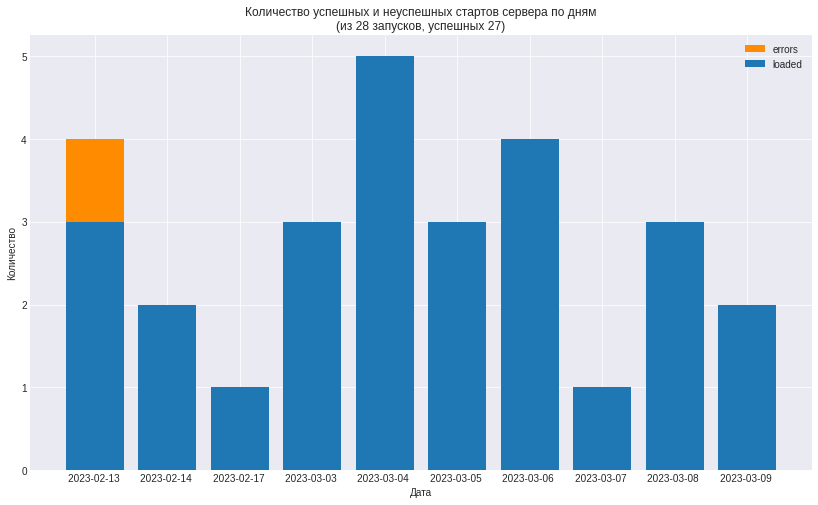

In [ ]:
# vibo: data
groups_x = plot_df.groupby(['date']).count().index
values_y_building = plot_df['count_mess'][plot_df['serv_mess'] == 'building'].values
values_y_loaded = plot_df['count_mess'][plot_df['serv_mess'] == 'loaded'].values

# vibo: bar chart whith
# vibo: здесь можно поиграться с номером темы (0-27)
plot_style = 16
with plt.style.context(plt.style.available[plot_style]):
  fig, ax = plt.subplots(figsize=(14, 8))
  ax.bar(groups_x, values_y_building, label = "errors", color='darkorange')
  ax.bar(groups_x, values_y_loaded, label = "loaded")

  plt.title(f'Количество успешных и неуспешных стартов сервера по дням\n(из {sum(values_y_building)} запусков, успешных {sum(values_y_loaded)})')
  ax.legend(loc='best')
  ax.set_xlabel('Дата')
  ax.set_ylabel('Количество')
  plt.show()

In [ ]:
plot_df = plot_df.groupby(['serv_mess']).sum().reset_index()
plot_df = plot_df.sort_values('count_mess', ascending=False)

# vibo: считаем количество ошибок
find_list = list(plot_df['count_mess'].values)
count_errors = find_list[0] - find_list[1]

# vibo: создаем датафрейм с ошибками
plot_df_err = pd.DataFrame({'serv_mess': ['errors'], 'count_mess': [count_errors]})
# vibo: добавляем строку с ошибкой
plot_df = plot_df.append(plot_df_err, ignore_index=True)

plot_df

<ipython-input-92-79ac21a49c99>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(plot_df_err, ignore_index=True)


,serv_mess,count_mess
0,building,28
1,loaded,27
2,errors,1


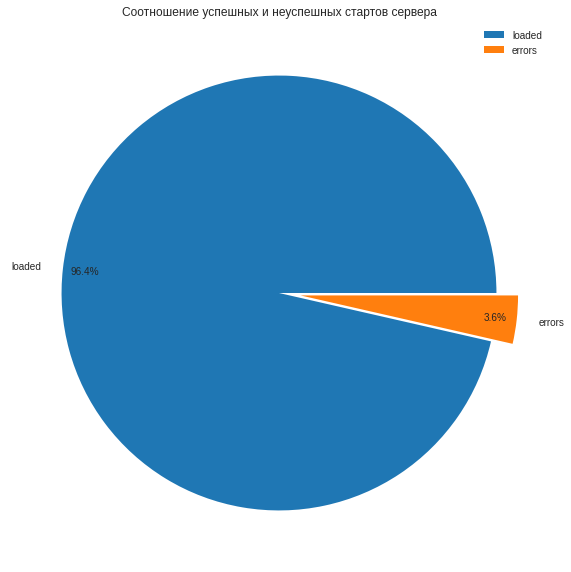

In [ ]:
labels = plot_df['serv_mess'][1:3].values
value = plot_df['count_mess'][1:3].values

# vibo: pie chart
# vibo: здесь можно поиграться с номером темы (0-27)
plot_style = 16
with plt.style.context(plt.style.available[plot_style]):
  fig, ax = plt.subplots(figsize=(10, 10))
  explode = [0, 0.1]
  ax.pie(value, labels=labels, pctdistance=0.9, explode=explode, autopct='%1.1f%%', labeldistance=1.1)

  plt.title(f'Соотношение успешных и неуспешных стартов сервера')
  ax.legend(loc='best')
  plt.show()

## 4.1.2 Worker-Main

Смотрим на сообщения в категории `Worker-Main`

In [ ]:
summary[summary['serv_teg_inf'] == 'Worker-Main']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
129,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,NaN,4.0,NaN
130,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,NaN,4.0,NaN
131,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,NaN,6.0,NaN
132,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,NaN,7.0,NaN
133,2023-02-13,21:34:32,Worker-Main,INFO,Preparing spawn area: 0%,NaN,6.0,NaN
...,...,...,...,...,...,...,...,...
6506,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 13%,NaN,7.0,NaN
6507,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 35%,NaN,7.0,NaN
6508,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 62%,NaN,4.0,NaN
6509,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 83%,NaN,3.0,NaN


In [ ]:
summary[summary['serv_teg_inf'] == 'Worker-Main'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 129 to 6510
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       891 non-null    object 
 1   time                       891 non-null    object 
 2   serv_teg_inf               891 non-null    object 
 3   serv_teg                   891 non-null    object 
 4   serv_mess                  891 non-null    object 
 5   user_authenticator_number  0 non-null      float64
 6   worker_main_number         891 non-null    float64
 7   async_chat_thread_number   0 non-null      float64
dtypes: float64(3), object(5)
memory usage: 62.6+ KB


Видно, что два столбца из рассмотрения можно сразу исключить, выделим данные в отдельный датафрейм

In [ ]:
sub_summary = summary[summary['serv_teg_inf'] == 'Worker-Main'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'worker_main_number']]
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess,worker_main_number
129,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,4.0
130,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,4.0
131,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,6.0
132,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,7.0
133,2023-02-13,21:34:32,Worker-Main,INFO,Preparing spawn area: 0%,6.0
...,...,...,...,...,...,...
6506,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 13%,7.0
6507,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 35%,7.0
6508,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 62%,4.0
6509,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 83%,3.0


In [ ]:
sub_summary[sub_summary['serv_teg_inf'] == 'Worker-Main'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess
count,891,891,891,891,891
unique,10,213,1,1,85
top,2023-03-04,18:28:23,Worker-Main,INFO,Preparing spawn area: 0%
freq,154,17,891,891,674


Самые популярные сообщения в категории `Worker-Main`

In [ ]:
# vibo: найдем самые популярные сообщения в категории
summary[summary['serv_teg_inf'] == 'Worker-Main']['serv_mess'].value_counts()

 Preparing spawn area: 0%     674
 Preparing spawn area: 9%       8
 Preparing spawn area: 4%       7
 Preparing spawn area: 1%       7
 Preparing spawn area: 83%      7
                             ... 
 Preparing spawn area: 66%      1
 Preparing spawn area: 56%      1
 Preparing spawn area: 42%      1
 Preparing spawn area: 15%      1
 Preparing spawn area: 78%      1
Name: serv_mess, Length: 85, dtype: int64

In [ ]:
sub_summary['serv_mess_teg'] = sub_summary['serv_mess'].map(lambda x: ' '.join(x.split()[0:3])[:-1])
sub_summary['serv_mess_%'] = sub_summary['serv_mess'].map(lambda x: x.split()[3][:-1])
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess,worker_main_number,serv_mess_teg,serv_mess_%
129,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,4.0,Preparing spawn area,0
130,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,4.0,Preparing spawn area,0
131,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,6.0,Preparing spawn area,0
132,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,7.0,Preparing spawn area,0
133,2023-02-13,21:34:32,Worker-Main,INFO,Preparing spawn area: 0%,6.0,Preparing spawn area,0
...,...,...,...,...,...,...,...,...
6506,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 13%,7.0,Preparing spawn area,13
6507,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 35%,7.0,Preparing spawn area,35
6508,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 62%,4.0,Preparing spawn area,62
6509,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 83%,3.0,Preparing spawn area,83


In [ ]:
sub_summary = sub_summary[['date', 'time', 'worker_main_number', 'serv_mess_teg', 'serv_mess_%']]
sub_summary

,date,time,worker_main_number,serv_mess_teg,serv_mess_%
129,2023-02-13,21:34:31,4.0,Preparing spawn area,0
130,2023-02-13,21:34:31,4.0,Preparing spawn area,0
131,2023-02-13,21:34:31,6.0,Preparing spawn area,0
132,2023-02-13,21:34:31,7.0,Preparing spawn area,0
133,2023-02-13,21:34:32,6.0,Preparing spawn area,0
...,...,...,...,...,...
6506,2023-03-09,17:56:40,7.0,Preparing spawn area,13
6507,2023-03-09,17:56:40,7.0,Preparing spawn area,35
6508,2023-03-09,17:56:41,4.0,Preparing spawn area,62
6509,2023-03-09,17:56:41,3.0,Preparing spawn area,83


## 4.1.3 User Authenticator

Смотрим на сообщения в категории `User Authenticator`

In [ ]:
summary[summary['serv_teg_inf'] == 'User Authenticator']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,user_name,uuid
393,2023-02-13,21:49:48,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
566,2023-02-13,22:01:24,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
914,2023-02-14,23:53:33,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
1095,2023-02-17,19:05:26,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,1.0,NaN,NaN,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff
1101,2023-02-17,19:07:53,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,2.0,NaN,NaN,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff
...,...,...,...,...,...,...,...,...,...,...
6535,2023-03-09,17:58:27,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,1.0,NaN,NaN,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5
6540,2023-03-09,18:01:54,User Authenticator,INFO,UUID of player ARTEEXX is 8c767e42-029f-3dee-...,2.0,NaN,NaN,ARTEEXX,8c767e42-029f-3dee-99c9-1bccb126c2d8
6546,2023-03-09,18:04:00,User Authenticator,INFO,UUID of player AARRTTEEXX is 843fa0f7-aebb-3f...,3.0,NaN,NaN,AARRTTEEXX,843fa0f7-aebb-3f41-ba00-efc9ea7989f8
6553,2023-03-09,18:16:03,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,4.0,NaN,NaN,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5


In [ ]:
summary[summary['serv_teg_inf'] == 'User Authenticator'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 393 to 6577
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       93 non-null     object 
 1   time                       93 non-null     object 
 2   serv_teg_inf               93 non-null     object 
 3   serv_teg                   93 non-null     object 
 4   serv_mess                  93 non-null     object 
 5   user_authenticator_number  93 non-null     float64
 6   worker_main_number         0 non-null      float64
 7   async_chat_thread_number   0 non-null      float64
 8   user_name                  93 non-null     object 
 9   uuid                       93 non-null     object 
dtypes: float64(3), object(7)
memory usage: 8.0+ KB


Видно, что последние два столбца из рассмотрения можно сразу исключить, выделим данные в отдельный датафрейм

In [ ]:
sub_summary = summary[summary['serv_teg_inf'] == 'User Authenticator'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'user_authenticator_number']]
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number
393,2023-02-13,21:49:48,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0
566,2023-02-13,22:01:24,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0
914,2023-02-14,23:53:33,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0
1095,2023-02-17,19:05:26,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,1.0
1101,2023-02-17,19:07:53,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,2.0
...,...,...,...,...,...,...
6535,2023-03-09,17:58:27,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,1.0
6540,2023-03-09,18:01:54,User Authenticator,INFO,UUID of player ARTEEXX is 8c767e42-029f-3dee-...,2.0
6546,2023-03-09,18:04:00,User Authenticator,INFO,UUID of player AARRTTEEXX is 843fa0f7-aebb-3f...,3.0
6553,2023-03-09,18:16:03,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,4.0


In [ ]:
sub_summary[['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess
count,93,93,93,93,93
unique,10,93,1,1,21
top,2023-03-06,21:49:48,User Authenticator,INFO,UUID of player testing1 is 4e9071c3-79ab-3a3a...
freq,24,1,93,93,15


Самые популярные сообщения в категории `User Authenticator`

In [ ]:
# vibo: найдем самые популярные сообщения в категории
summary[summary['serv_teg_inf'] == 'User Authenticator']['serv_mess'].value_counts()

 UUID of player testing1 is 4e9071c3-79ab-3a3a-ab83-2e04eacd6854            15
 UUID of player YOUTUBE_plaY is 56eb670a-4ed0-3009-9bc9-00d047fbaeff        14
 UUID of player amogoos is bb8d3a15-62ea-3dd7-8df8-776e0930f557             12
 UUID of player testing2 is 5e20431e-cf2a-314e-a557-c5525d567366             9
 UUID of player vibo is f4a7e80b-36fa-3e7a-814b-9824a8ccd5f9                 7
 UUID of player rex is 74d83d51-5bf6-37fb-8395-9a0590a59259                  6
 UUID of player testing3 is 0c9c0d31-79b7-3cc6-894a-5b40d339bd72             4
 UUID of player ARTEXX is ee86a614-d39f-3a50-aef4-d8029433b0f5               3
 UUID of player aaaaa is 77cc7b98-f829-305b-9a13-dbb088fbd0f5                3
 UUID of player Fredi is 1ee24d02-4446-35e1-84c8-4b785c1bae33                3
 UUID of player vibO is 426ba0c3-6437-3e82-b36b-ca953fb41a42                 3
 UUID of player gggggg102 is d755a875-1b70-3b66-bd19-b2b67e593159            3
 UUID of player _Rocket5500_ is a6be4875-0cf6-3c5a-9

Посмотрим на сообщения в категории `User Authenticator`, видим, что можем выделить `user_name` и `UUID`

In [ ]:
summary[summary['serv_teg_inf'] == 'User Authenticator']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,user_name,uuid
393,2023-02-13,21:49:48,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
566,2023-02-13,22:01:24,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
914,2023-02-14,23:53:33,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
1095,2023-02-17,19:05:26,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,1.0,NaN,NaN,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff
1101,2023-02-17,19:07:53,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,2.0,NaN,NaN,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff
...,...,...,...,...,...,...,...,...,...,...
6535,2023-03-09,17:58:27,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,1.0,NaN,NaN,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5
6540,2023-03-09,18:01:54,User Authenticator,INFO,UUID of player ARTEEXX is 8c767e42-029f-3dee-...,2.0,NaN,NaN,ARTEEXX,8c767e42-029f-3dee-99c9-1bccb126c2d8
6546,2023-03-09,18:04:00,User Authenticator,INFO,UUID of player AARRTTEEXX is 843fa0f7-aebb-3f...,3.0,NaN,NaN,AARRTTEEXX,843fa0f7-aebb-3f41-ba00-efc9ea7989f8
6553,2023-03-09,18:16:03,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,4.0,NaN,NaN,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5


In [ ]:
summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['date'])['date'].count().to_frame(name='count_authent').reset_index()

,date,count_authent
0,2023-02-13,2
1,2023-02-14,1
2,2023-02-17,8
3,2023-03-03,11
4,2023-03-04,3
5,2023-03-05,17
6,2023-03-06,24
7,2023-03-07,10
8,2023-03-08,10
9,2023-03-09,7


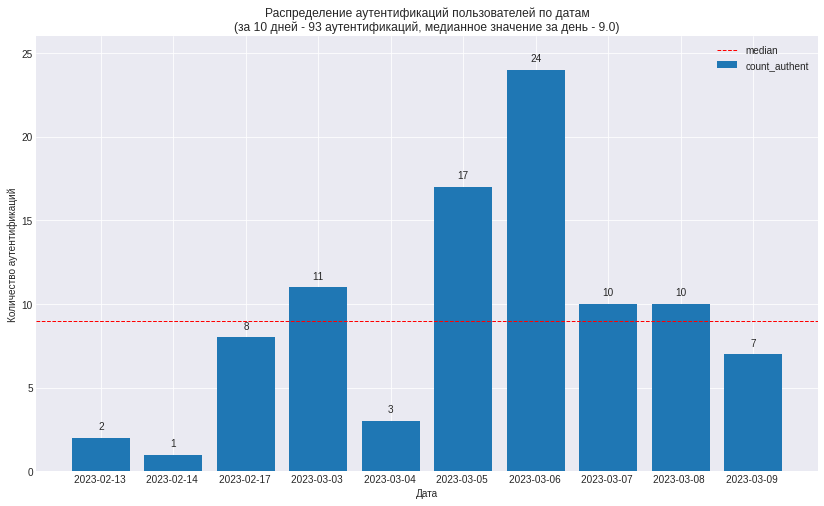

In [ ]:
# vibo: data
plot_df = summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['date'])['date'].count().to_frame(name='count_authent').reset_index()
groups_x = plot_df['date'].values
values_y = plot_df['count_authent'].values
med_authenticat = plot_df['count_authent'].describe()['50%']

# vibo: bar chart whith total value labels
# vibo: здесь можно поиграться с номером темы (0-27)
plot_style = 16
with plt.style.context(plt.style.available[plot_style]):
  fig, ax = plt.subplots(figsize=(14, 8))
  ax.bar(groups_x, values_y, label = "count_authent")

  for i, total in enumerate(values_y):
    ax.text(i, total + 0.5, values_y[i], ha='center')
  
  plt.axhline(y=med_authenticat, color='red', linestyle='--', linewidth=1, label='median')

  plt.title(f'Распределение аутентификаций пользователей по датам\n(за {len(groups_x)} дней - {sum(values_y)} аутентификаций, медианное значение за день - {med_authenticat})')
  ax.legend(loc='best')
  ax.set_xlabel('Дата')
  ax.set_ylim(0, 26)
  ax.set_ylabel('Количество аутентификаций')
  plt.show()

Пример расшифровки UUID из интернета

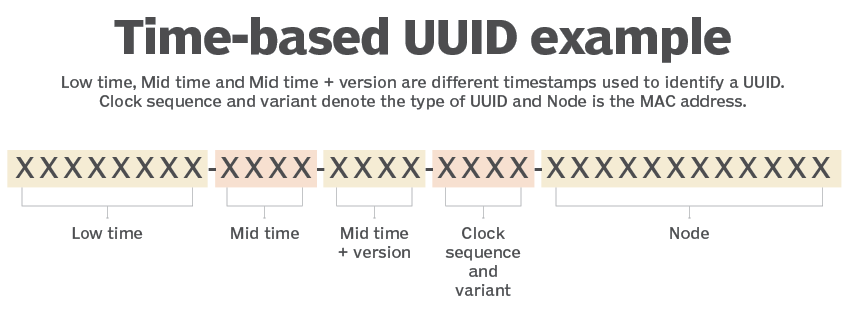

In [ ]:
# vibo: выделяем имя пользователя и его UUID
summary['user_name'] = summary[summary['serv_teg_inf'] == 'User Authenticator']['serv_mess'].map(lambda x: x.split()[3])
summary['uuid'] = summary[summary['serv_teg_inf'] == 'User Authenticator']['serv_mess'].map(lambda x: x.split()[5])
summary[summary['serv_teg_inf'] == 'User Authenticator'][['date', 'user_authenticator_number', 'user_name', 'uuid']]

,date,user_authenticator_number,user_name,uuid
393,2023-02-13,1.0,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
566,2023-02-13,1.0,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
914,2023-02-14,1.0,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
1095,2023-02-17,1.0,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff
1101,2023-02-17,2.0,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff
...,...,...,...,...
6535,2023-03-09,1.0,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5
6540,2023-03-09,2.0,ARTEEXX,8c767e42-029f-3dee-99c9-1bccb126c2d8
6546,2023-03-09,3.0,AARRTTEEXX,843fa0f7-aebb-3f41-ba00-efc9ea7989f8
6553,2023-03-09,4.0,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5


UUID привязан к имени пользователя

In [ ]:
# vibo: суммарное количество аутентификаций пользователей за период
summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['serv_mess']).size().sort_values(ascending=False)

serv_mess
 UUID of player testing1 is 4e9071c3-79ab-3a3a-ab83-2e04eacd6854            15
 UUID of player YOUTUBE_plaY is 56eb670a-4ed0-3009-9bc9-00d047fbaeff        14
 UUID of player amogoos is bb8d3a15-62ea-3dd7-8df8-776e0930f557             12
 UUID of player testing2 is 5e20431e-cf2a-314e-a557-c5525d567366             9
 UUID of player vibo is f4a7e80b-36fa-3e7a-814b-9824a8ccd5f9                 7
 UUID of player rex is 74d83d51-5bf6-37fb-8395-9a0590a59259                  6
 UUID of player testing3 is 0c9c0d31-79b7-3cc6-894a-5b40d339bd72             4
 UUID of player ARTEXX is ee86a614-d39f-3a50-aef4-d8029433b0f5               3
 UUID of player Fredi is 1ee24d02-4446-35e1-84c8-4b785c1bae33                3
 UUID of player vibO is 426ba0c3-6437-3e82-b36b-ca953fb41a42                 3
 UUID of player aaaaa is 77cc7b98-f829-305b-9a13-dbb088fbd0f5                3
 UUID of player gggggg102 is d755a875-1b70-3b66-bd19-b2b67e593159            3
 UUID of player LOLOTUK is 351abe30-df95-3

In [ ]:
plot_df = summary[summary['serv_teg_inf'] == 'User Authenticator'][['date', 'user_authenticator_number', 'user_name', 'uuid']]
plot_df = plot_df[['date', 'user_name', 'uuid', 'user_authenticator_number']]
plot_df

,date,user_name,uuid,user_authenticator_number
393,2023-02-13,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42,1.0
566,2023-02-13,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42,1.0
914,2023-02-14,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42,1.0
1095,2023-02-17,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff,1.0
1101,2023-02-17,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff,2.0
...,...,...,...,...
6535,2023-03-09,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5,1.0
6540,2023-03-09,ARTEEXX,8c767e42-029f-3dee-99c9-1bccb126c2d8,2.0
6546,2023-03-09,AARRTTEEXX,843fa0f7-aebb-3f41-ba00-efc9ea7989f8,3.0
6553,2023-03-09,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5,4.0


Здесь в столбце `user_authenticator_number` считается количество аутентификаций пользователя (возможно с разными именами) с одного лаунчера. Счетчик обнуляется каждый день. Два одинаковых значения `user_authenticator_number` за одну дату говорят об аутентицикации пользователя с одним имененем с двух разных лаунчеров.

In [ ]:
plot_df = plot_df.groupby(['user_name'])['user_authenticator_number'].count()
plot_df = plot_df.to_frame(name='count_auth').reset_index()
plot_df

,user_name,count_auth
0,AARRTTEEXX,1
1,ARTEEXX,1
2,ARTEXX,3
3,Fredi,3
4,LOLOTUK,2
5,Umni4ok100200,1
6,YOUTUBE_plaY,14
7,_Rocket5500_,2
8,aaaaa,3
9,amogoos,12


In [ ]:
plot_df = plot_df.sort_values('count_auth', ascending=False).reset_index(drop=True)
plot_df

,user_name,count_auth
0,testing1,15
1,YOUTUBE_plaY,14
2,amogoos,12
3,testing2,9
4,vibo,7
5,rex,6
6,testing3,4
7,ARTEXX,3
8,Fredi,3
9,vibO,3


In [ ]:
med_auth = plot_df['count_auth'].describe()['50%']
med_auth

3.0

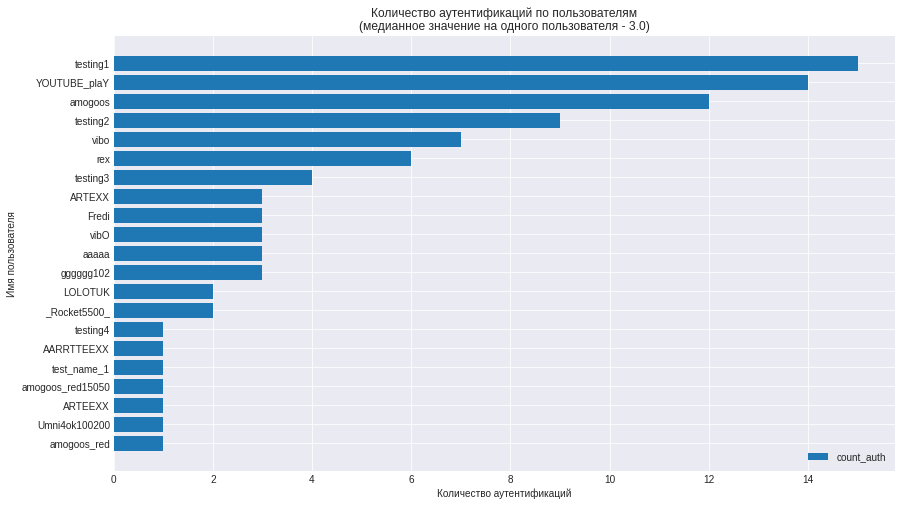

In [ ]:
# vibo: data
groups_x = plot_df['user_name'].values[::-1]
values_y = plot_df['count_auth'].values[::-1]

# vibo: bar chart whith
# vibo: здесь можно поиграться с номером темы (0-27)
plot_style = 16
with plt.style.context(plt.style.available[plot_style]):
  fig, ax = plt.subplots(figsize=(14, 8))
  ax.barh(groups_x, values_y, label = "count_auth")

  plt.title(f'Количество аутентификаций по пользователям\n(медианное значение на одного пользователя - {med_auth})')
  ax.legend(loc='best')
  ax.set_xlabel('Количество аутентификаций')
  ax.set_ylabel('Имя пользователя')
  plt.show()

In [ ]:
# vibo: уникальные аутентифицированные пользователи
sorted(list(summary[summary['serv_teg_inf'] == 'User Authenticator']['user_name'].unique()))

['AARRTTEEXX',
 'ARTEEXX',
 'ARTEXX',
 'Fredi',
 'LOLOTUK',
 'Umni4ok100200',
 'YOUTUBE_plaY',
 '_Rocket5500_',
 'aaaaa',
 'amogoos',
 'amogoos_red',
 'amogoos_red15050',
 'gggggg102',
 'rex',
 'test_name_1',
 'testing1',
 'testing2',
 'testing3',
 'testing4',
 'vibO',
 'vibo']

In [ ]:
# vibo: уникальные UUID
sorted(list(summary[summary['serv_teg_inf'] == 'User Authenticator']['uuid'].unique()))

['0c9c0d31-79b7-3cc6-894a-5b40d339bd72',
 '1ee24d02-4446-35e1-84c8-4b785c1bae33',
 '319be620-93f2-3b87-8414-d9f733460955',
 '351abe30-df95-37d4-940e-b868831fc026',
 '426ba0c3-6437-3e82-b36b-ca953fb41a42',
 '4e9071c3-79ab-3a3a-ab83-2e04eacd6854',
 '56eb670a-4ed0-3009-9bc9-00d047fbaeff',
 '5e20431e-cf2a-314e-a557-c5525d567366',
 '74d83d51-5bf6-37fb-8395-9a0590a59259',
 '77cc7b98-f829-305b-9a13-dbb088fbd0f5',
 '843fa0f7-aebb-3f41-ba00-efc9ea7989f8',
 '8c767e42-029f-3dee-99c9-1bccb126c2d8',
 '90c58b0a-047b-3f41-a2eb-0b295facaf2a',
 '9f566d31-b9cd-3069-9068-967914755363',
 'a101608a-3944-3398-a11e-16211546e19a',
 'a6be4875-0cf6-3c5a-9d9f-b226ad3a4bc1',
 'b78a67d1-e667-3841-a463-64fdf66f2484',
 'bb8d3a15-62ea-3dd7-8df8-776e0930f557',
 'd755a875-1b70-3b66-bd19-b2b67e593159',
 'ee86a614-d39f-3a50-aef4-d8029433b0f5',
 'f4a7e80b-36fa-3e7a-814b-9824a8ccd5f9']

In [ ]:
# vibo: количество уникальных аутентицированных пользователей
len(list(summary[summary['serv_teg_inf'] == 'User Authenticator']['user_name'].unique()))

21

In [ ]:
len(list(summary[summary['serv_teg_inf'] == 'User Authenticator']['uuid'].unique()))

21

In [ ]:
# vibo: количество аутентификаций пользователей по дням с группировкой по пользователям
summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['date', 'user_name'])[['user_name']].size()

date         user_name       
2023-02-13   vibO                 2
2023-02-14   vibO                 1
2023-02-17   YOUTUBE_plaY         5
             vibo                 3
2023-03-03   LOLOTUK              2
             YOUTUBE_plaY         6
             rex                  3
2023-03-04   rex                  3
2023-03-05   YOUTUBE_plaY         3
             amogoos              7
             amogoos_red          1
             amogoos_red15050     1
             gggggg102            1
             testing1             1
             vibo                 3
2023-03-06   amogoos              2
             testing1            13
             testing2             7
             testing3             1
             testing4             1
2023-03-07   Fredi                3
             amogoos              3
             gggggg102            2
             test_name_1          1
             testing1             1
2023-03-08   Umni4ok100200        1
             aaaaa                

## 4.1.4 Async Chat Thread

Смотрим на сообщения в категории `Async Chat Thread`

In [ ]:
summary[summary['serv_teg_inf'] == 'Async Chat Thread']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,user_name,uuid
1153,2023-02-17,19:41:22,Async Chat Thread,INFO,[Not Secure] <vibo> привет!!!,NaN,NaN,0.0,NaN,NaN
1154,2023-02-17,19:41:54,Async Chat Thread,INFO,[Not Secure] <vibo> ты можешь выдать мне прав...,NaN,NaN,0.0,NaN,NaN
1155,2023-02-17,19:42:08,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> да да,NaN,NaN,0.0,NaN,NaN
1157,2023-02-17,19:43:23,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> всё дал,NaN,NaN,2.0,NaN,NaN
1164,2023-02-17,19:45:47,Async Chat Thread,INFO,[Not Secure] <vibo> спасибо! все получилось,NaN,NaN,4.0,NaN,NaN
1169,2023-02-17,19:48:23,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> давй пвп,NaN,NaN,6.0,NaN,NaN
1170,2023-02-17,19:48:36,Async Chat Thread,INFO,[Not Secure] <vibo> давай,NaN,NaN,6.0,NaN,NaN
1173,2023-02-17,19:49:04,Async Chat Thread,INFO,[Not Secure] <vibo> ты готов?,NaN,NaN,6.0,NaN,NaN
1191,2023-02-17,20:05:41,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> что будем делать,NaN,NaN,8.0,NaN,NaN
1192,2023-02-17,20:07:01,Async Chat Thread,INFO,[Not Secure] <vibo> я убрал лаву,NaN,NaN,10.0,NaN,NaN


In [ ]:
summary[summary['serv_teg_inf'] == 'Async Chat Thread'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 1153 to 5744
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       19 non-null     object 
 1   time                       19 non-null     object 
 2   serv_teg_inf               19 non-null     object 
 3   serv_teg                   19 non-null     object 
 4   serv_mess                  19 non-null     object 
 5   user_authenticator_number  0 non-null      float64
 6   worker_main_number         0 non-null      float64
 7   async_chat_thread_number   19 non-null     float64
 8   user_name                  0 non-null      object 
 9   uuid                       0 non-null      object 
dtypes: float64(3), object(7)
memory usage: 1.6+ KB


Видно, что некоторые столбцы из рассмотрения можно сразу исключить, выделим данные в отдельный датафрейм

In [ ]:
sub_summary = summary[summary['serv_teg_inf'] == 'Async Chat Thread'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'async_chat_thread_number']]
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess,async_chat_thread_number
1153,2023-02-17,19:41:22,Async Chat Thread,INFO,[Not Secure] <vibo> привет!!!,0.0
1154,2023-02-17,19:41:54,Async Chat Thread,INFO,[Not Secure] <vibo> ты можешь выдать мне прав...,0.0
1155,2023-02-17,19:42:08,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> да да,0.0
1157,2023-02-17,19:43:23,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> всё дал,2.0
1164,2023-02-17,19:45:47,Async Chat Thread,INFO,[Not Secure] <vibo> спасибо! все получилось,4.0
1169,2023-02-17,19:48:23,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> давй пвп,6.0
1170,2023-02-17,19:48:36,Async Chat Thread,INFO,[Not Secure] <vibo> давай,6.0
1173,2023-02-17,19:49:04,Async Chat Thread,INFO,[Not Secure] <vibo> ты готов?,6.0
1191,2023-02-17,20:05:41,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> что будем делать,8.0
1192,2023-02-17,20:07:01,Async Chat Thread,INFO,[Not Secure] <vibo> я убрал лаву,10.0


In [ ]:
sub_summary[sub_summary['serv_teg_inf'] == 'Async Chat Thread'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess
count,19,19,19,19,19
unique,4,19,1,1,19
top,2023-02-17,19:41:22,Async Chat Thread,INFO,[Not Secure] <vibo> привет!!!
freq,12,1,19,19,1


Самые популярные сообщения в категории `Async Chat Thread`

In [ ]:
# vibo: найдем самые популярные сообщения в категории
summary[summary['serv_teg_inf'] == 'Async Chat Thread']['serv_mess'].value_counts()

 [Not Secure] <vibo> привет!!!                                                      1
 [Not Secure] <YOUTUBE_plaY> выбераеш ты                                            1
 [Not Secure] <vibo> как ты поменял цвет маяка?                                     1
 [Not Secure] <amogoos> дааааааааада                                                1
 [Not Secure] <vibo> ты меня слышышь?                                               1
 [Not Secure] <vibo> прием                                                          1
 [Not Secure] <amogoos> amogoos red                                                 1
 [Not Secure] <rex> fhgfjhgj                                                        1
 [Not Secure] <vibo> хочу понять как делать спавн поинт для новых игроков           1
 [Not Secure] <vibo> я убрал лаву                                                   1
 [Not Secure] <vibo> ты можешь выдать мне права админа на твоем сервере?            1
 [Not Secure] <YOUTUBE_plaY> что будем делать         

Здесь чат маленький, интересно посмотреть при большем количестве информации, найти наиболее часто употребляемые слова, каждого игрока отдельно и т.д.